# 3.4 Stacking and interpolating data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Let's first test your NASA login:

In [2]:
import geog0111.nasa_requests as nasa_requests
from geog0111.cylog import cylog

url = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/' 
        
# grab the HTML information
try:
    html = nasa_requests.get(url).text
    # test a few lines of the html
    if html[:20] == '<!DOCTYPE HTML PUBLI':
        print('this seems to be ok ... ')
        print('use cylog().login() anywhere you need to specify the tuple (username,password)')
except:
    print('login error ... try entering your username password again')
    print('then re-run this cell until it works')
    cylog(init=True)

this seems to be ok ... 
use cylog().login() anywhere you need to specify the tuple (username,password)


## 3.4.1 A time series

You should now know how to access and download datasets from the NASA servers and have developed functions to do this.

You should also know how to select a dataset from a set of hdf files, and mosaic, mask and crop the data to correspond to some vector boundary. This is a very common task in geospatial processing.

We now consider the case where we want to analyse a time series of data. We will use LAI over time to exemplify this.



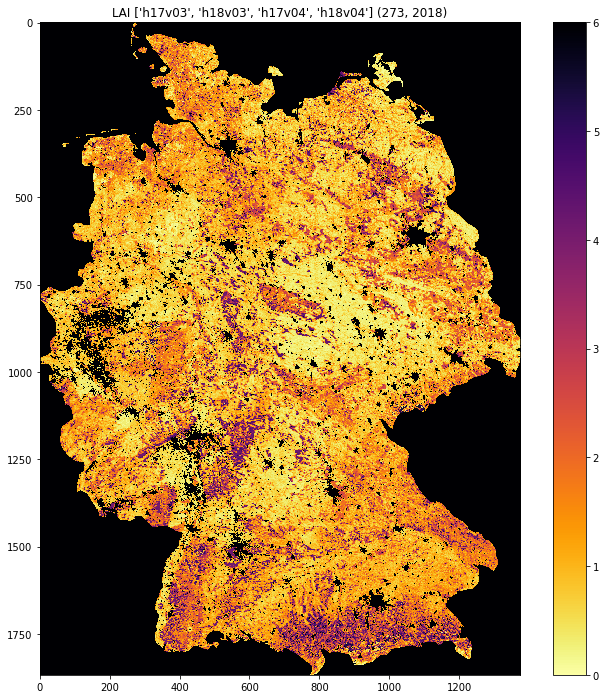

In [6]:
from geog0111.get_modis_files import get_modis_files
import gdal
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

doy,year = 273,2018
tiles = ['h17v03', 'h18v03','h17v04', 'h18v04']
destination_folder = 'data'

filenames = get_modis_files(doy,year,tiles,base_url='https://e4ftl01.cr.usgs.gov/MOTA',\
                                           version=6,\
                                           product='MCD15A3H')



#def process_data(doy_year,tiles,vector_file, vector_where):
    
    
def mosaic_and_mask_data(gdal_fnames, vector_file, vector_where):
    stitch_vrt = gdal.BuildVRT("", gdal_fnames)
    g = gdal.Warp("", stitch_vrt,
                 format = 'MEM', dstNodata=200,
                  cutlineDSName = vector_file,
                  cutlineWhere = vector_where)
    return g


# this part is to access a particular dataset in the file
gdal_fnames = [f'HDF4_EOS:EOS_GRID:"{file_name:s}":MOD_Grid_MCD15A3H:Lai_500m'
               for file_name in filenames]

g = mosaic_and_mask_data(gdal_fnames, "data/TM_WORLD_BORDERS-0.3.shp",
                         "FIPS='GM'")

lai = np.array(g.ReadAsArray()).astype(float) * 0.1 # for LAI scaling
# valid data mask
mask = np.nonzero(lai < 20)
min_y = mask[0].min()
max_y = mask[0].max() + 1

min_x = mask[1].min()
max_x = mask[1].max() + 1

lai = lai[min_y:max_y,
               min_x:max_x]

fig = plt.figure(figsize=(12,12))
im = plt.imshow(lai, interpolation="nearest", vmin=0, vmax=6,
             cmap=plt.cm.inferno_r)
plt.title('LAI'+' '+str(tiles)+' '+str((doy,year)))
plt.colorbar()